In [ ]:
import sys; sys.path.append("../")

from vle.utils import instantiate_from_config, load_config

import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

In [2]:
base = "/fsx/home/johnathan/variable-length-embeddings/configs/single-image-test-config2.yaml"
config = load_config(base)
model = instantiate_from_config(config["model"]).cuda()
dataset = instantiate_from_config(config["data"])
dataloader = dataset.train_dataloader()
batch = next(iter(dataloader)).cuda()

epsilon = 1e-4

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
/fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
AspectRatiosBatcher::cache_bins: [(512, 512), (576, 448), (448, 576), (704, 384), (384, 704)]
Loading webdataset with 98854 shards.


In [3]:
def lr_lambda_fn(step):
    return 0.95

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda_fn)

lpips_loss = model.lpips_loss

def loss_fn(
    use_lpips=False, 
    use_aux=False, 
    use_kld=True, 
    use_bce=False, 
    bce_mult=1e-1, 
    int_mult=1e-1, 
    kld_mult=1.0, 
    lpips_mult=1e-1,
):
    def wrapped_fn(outputs, inputs, intermediates):
        kld_loss = 0.0
        int_rec_loss = 0.0
        int_bce_loss = 0.0
        
        prev_i_rec = None
        rec = torch.zeros_like(inputs)
        for i_rec, z_token in zip(intermediates["tokens"], intermediates["z_tokens"]):
            i_z_mu, i_z_logvar, _ = z_token

            # Compute intermediate losses
            if use_kld:
                mu, log_var = i_z_mu.flatten(start_dim=1), i_z_logvar.flatten(start_dim=1)
                kld_loss += torch.mean(
                    -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
                ) / torch.numel(rec[0])
            if use_aux:
                int_rec_loss += F.mse_loss(inputs, i_rec)
                
            if use_bce and prev_i_rec is not None:
                i_rec_norm = torch.abs(i_rec)
                i_rec_norm = i_rec_norm / (
                    torch.amax(i_rec_norm, dim=(-2, -1), keepdim=True) + epsilon
                )
                i_rec_norm = torch.clamp(i_rec_norm, epsilon, 1 - epsilon)

                rec_norm = torch.abs(rec)
                rec_norm = rec_norm / (
                    torch.amax(rec_norm, dim=(-2, -1), keepdim=True) + epsilon
                )
                rec_norm = torch.clamp(rec_norm, epsilon, 1 - epsilon)
                int_bce_loss -= F.binary_cross_entropy(i_rec_norm, rec_norm)
            
            rec = rec + (i_rec * std + mean)
            prev_i_rec = i_rec
            
        # Compute final losses
        loss = F.mse_loss(inputs, rec)
        p_loss = 0.0
        if use_lpips:
            # TODO: Rescale LPIPS
            p_loss = lpips_loss(inputs, rec).mean() * lpips_mult

        int_rec_loss *= int_mult
        kld_loss *= kld_mult
        int_bce_loss *= bce_mult

        # Average intermediate losses
        n_tokens = len(intermediates["tokens"])
        int_rec_loss /= n_tokens
        kld_loss /= n_tokens

        return loss, int_rec_loss, p_loss, kld_loss, int_bce_loss
    return wrapped_fn

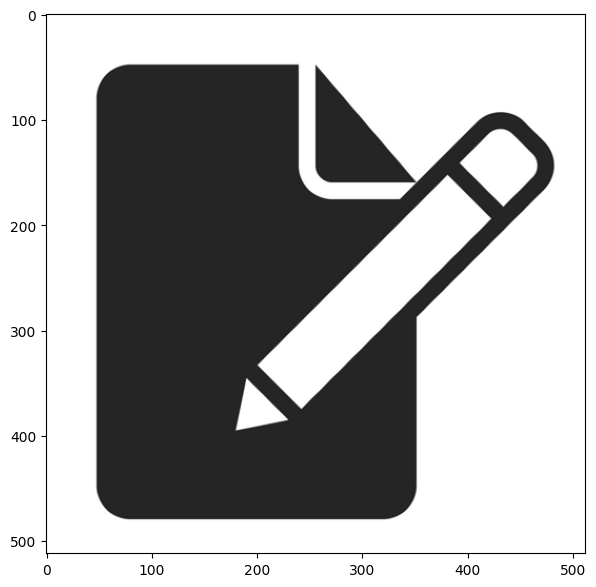

In [4]:
loss_metric = loss_fn(use_lpips=False, use_aux=False, use_bce=False, use_kld=True, kld_mult=0.01, bce_mult=1e-2)
max_tokens = 5

example_idx = 3

def folded_normal_pdf(x, mu=0.0, sigma=1.0):
    sig_squared = sigma**2
    left_half = 1 / np.sqrt(2 * np.pi * sig_squared)
    left_half = left_half * np.exp(-1 * (x - mu) ** 2 / (2 * sig_squared))

    right_half = 1 / np.sqrt(2 * np.pi * sig_squared)
    right_half = right_half * np.exp(-1 * (x + mu) ** 2 / (2 * sig_squared))

    return left_half + right_half

def sample_n_tokens(step, token_dist_update_step):
    tokens_range = np.arange(1, max_tokens + 1)
    n_tokens_p = (
        folded_normal_pdf(
            tokens_range - 1,
            min(
                int(step / token_dist_update_step), max_tokens
            ),
        )
        + epsilon
    )
    n_tokens_p = n_tokens_p / np.sum(n_tokens_p)
    n_tokens = np.random.choice(tokens_range, p=n_tokens_p)
    return n_tokens


postprocess = lambda x: np.clip((x.moveaxis(0, -1).cpu().detach().numpy() * 255), 0, 255).astype(int)
def training_loop(batch, iters=1000, print_every_n=100, lr_update=100, resample_tokens_dist=100):
    for i in range(iters):
#         n_tokens = np.random.randint(1, max_tokens + 1)
        n_tokens = sample_n_tokens(i, resample_tokens_dist)
        optimizer.zero_grad()

        outputs, tokens = model(batch, n_tokens, ret_tokens=True, ret_z=True)
        mse_loss, int_rec_loss, p_loss, kld_loss, int_bce_loss = loss_metric(outputs, batch, tokens)
        loss = mse_loss + int_rec_loss + p_loss + kld_loss + int_bce_loss
        
        loss.backward()
        optimizer.step()
        if (i + 1) % lr_update == 0:
            lr_scheduler.step()
        
        if i % print_every_n == 0:
            print_statement = f"Iteration {i}: {loss:.5f} "
            print_statement += f"(reconstruction_loss: {mse_loss:.5f}, aux_loss: {int_rec_loss:.5f}, "
            print_statement += f"p_loss: {p_loss:.5f}, kld_koss: {kld_loss:.5f}, bce_loss: {int_bce_loss:.5f})"
            print_statement += f", (lr: {lr_scheduler.get_lr()[0]})"
            print(print_statement)

            fig, axes = plt.subplots(3, n_tokens, figsize=(20, 10))
            rec = torch.zeros_like(batch)
            for j, tup in enumerate(tokens["tokens"]):
                token, std, mean = tup
                delta = token * std + mean
                rec = rec + delta
                hm = np.linalg.norm(postprocess(delta[example_idx]), axis=-1)
                if n_tokens == 1:
                    axes[0].imshow(hm, cmap='hot'); axes[0].axis('off')
                    axes[1].imshow(postprocess(rec[example_idx])); axes[1].axis('off')
                    axes[2].hist((batch[example_idx] - rec[example_idx]).cpu().detach().numpy().flatten(), bins=50)
                else:                    
                    axes[0,j].imshow(hm, cmap='hot'); axes[0,j].axis('off')
                    axes[1,j].imshow(postprocess(rec[example_idx])); axes[1,j].axis('off')
                    axes[2,j].hist((batch[example_idx] - rec[example_idx]).cpu().detach().numpy().flatten(), bins=50)
            plt.show()
    
        del tokens
        
plt.figure(figsize=(20, 7))
plt.imshow(postprocess(batch[example_idx]))

plt.show()

Iteration 0: 0.36982 (reconstruction_loss: 0.36982, aux_loss: 0.00000, p_loss: 0.00000, kld_koss: 0.00000, bce_loss: 0.00000), (lr: 0.0003)


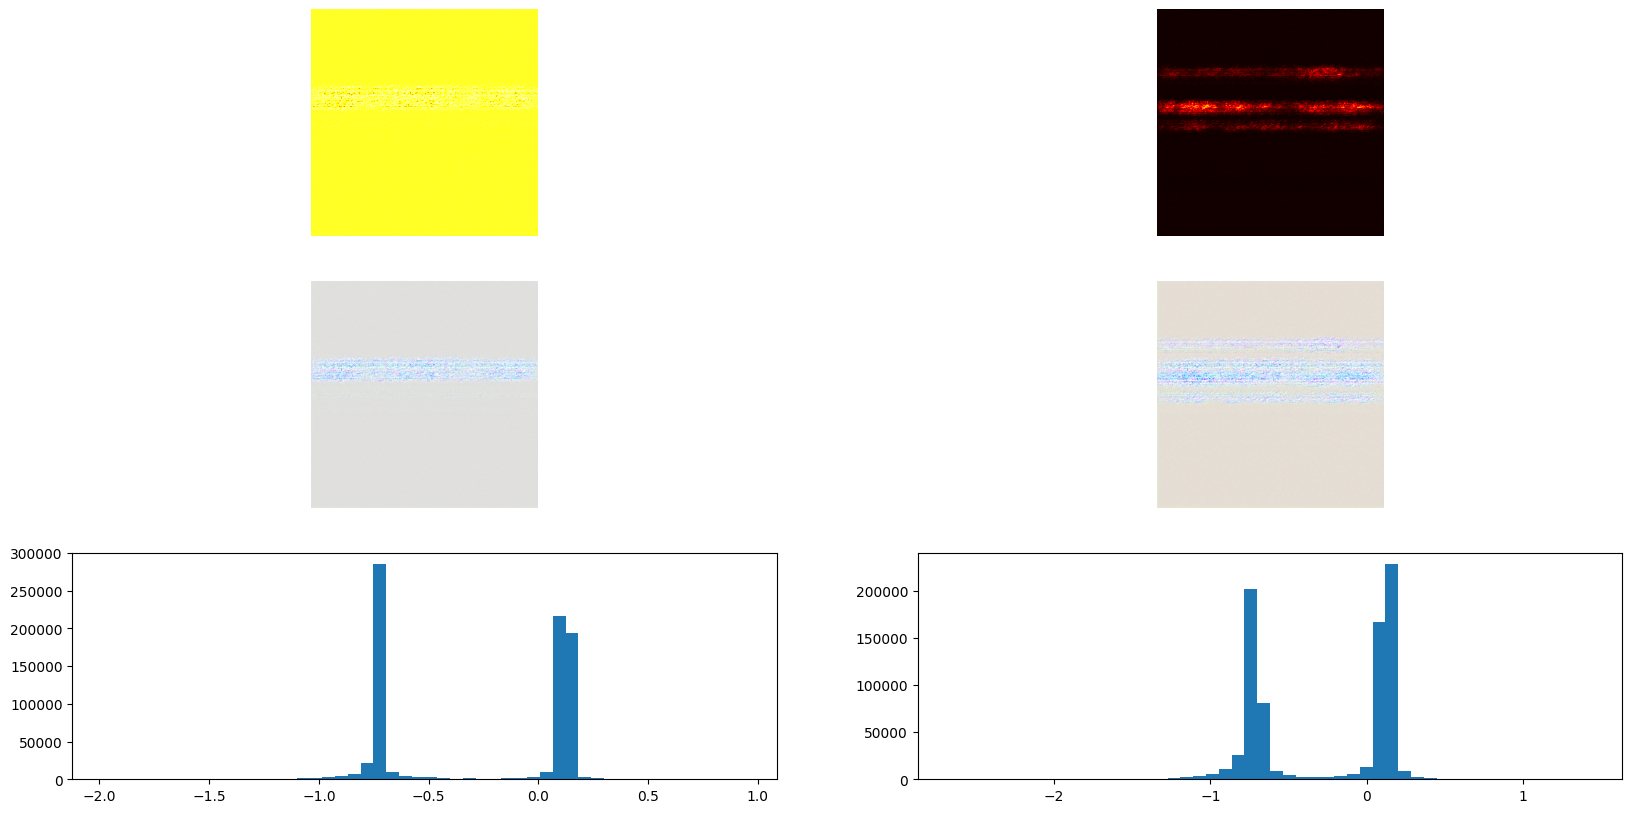

Iteration 100: 0.22088 (reconstruction_loss: 0.22075, aux_loss: 0.00000, p_loss: 0.00000, kld_koss: 0.00013, bce_loss: 0.00000), (lr: 0.0003)


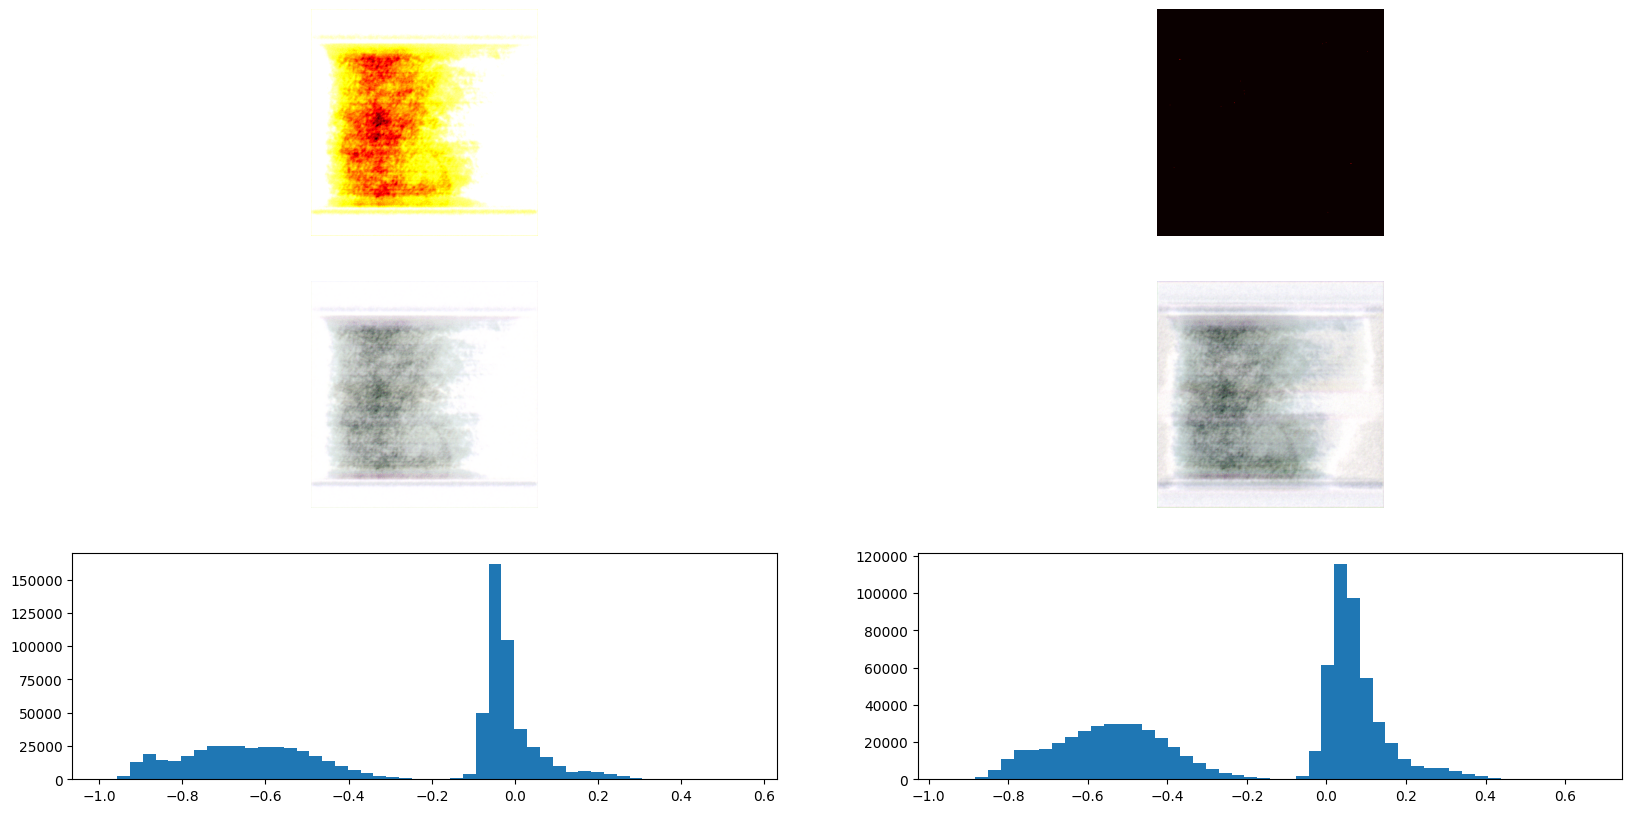

Iteration 200: 0.36293 (reconstruction_loss: 0.36280, aux_loss: 0.00000, p_loss: 0.00000, kld_koss: 0.00013, bce_loss: 0.00000), (lr: 0.00027075)


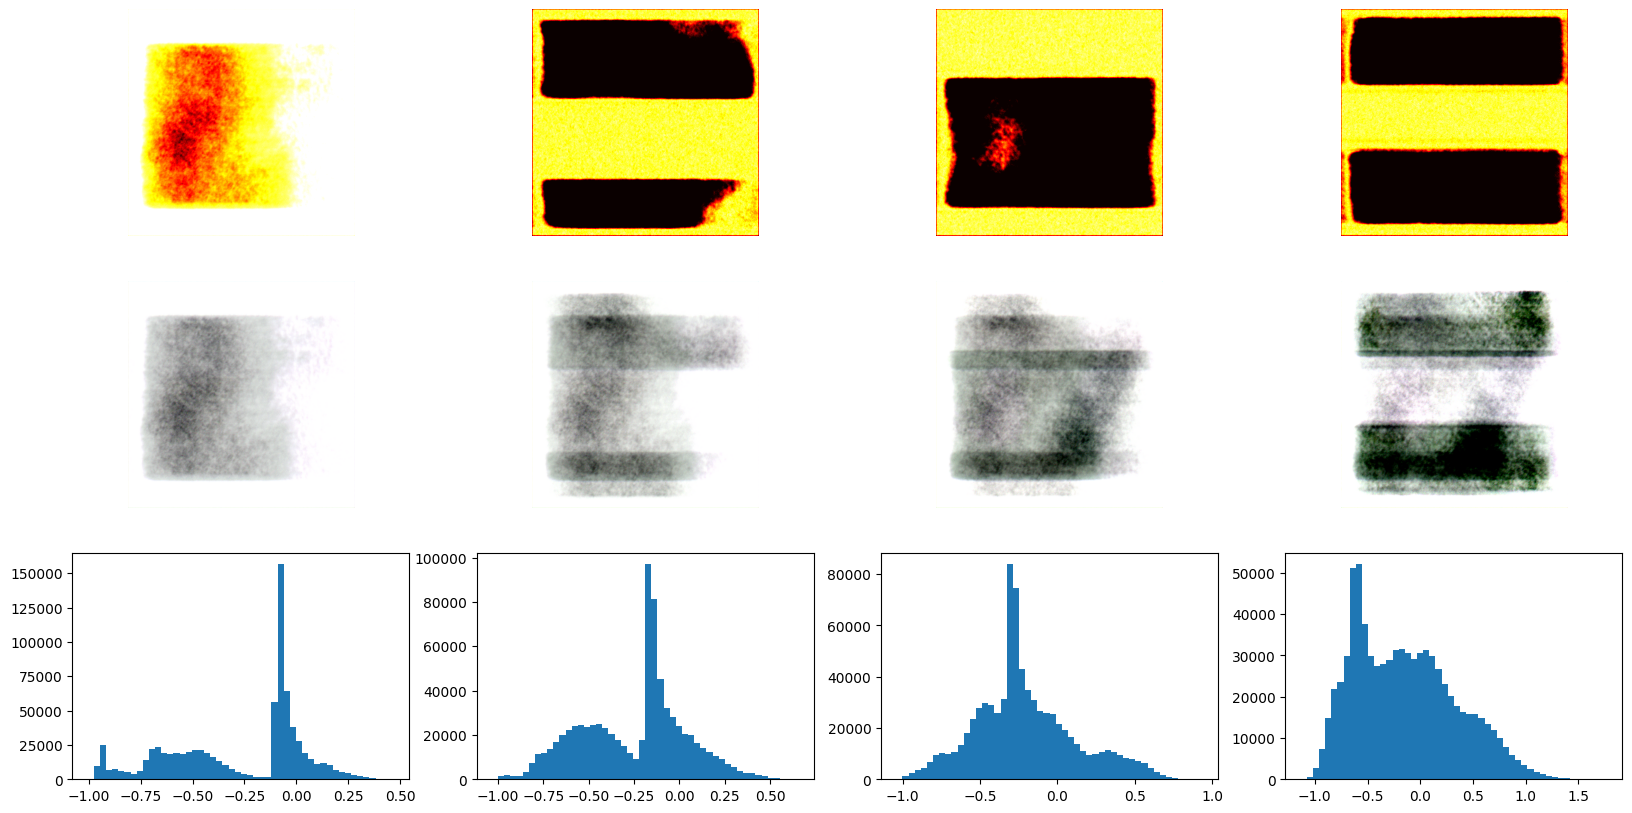

Iteration 300: 0.18782 (reconstruction_loss: 0.18770, aux_loss: 0.00000, p_loss: 0.00000, kld_koss: 0.00012, bce_loss: 0.00000), (lr: 0.00027075)


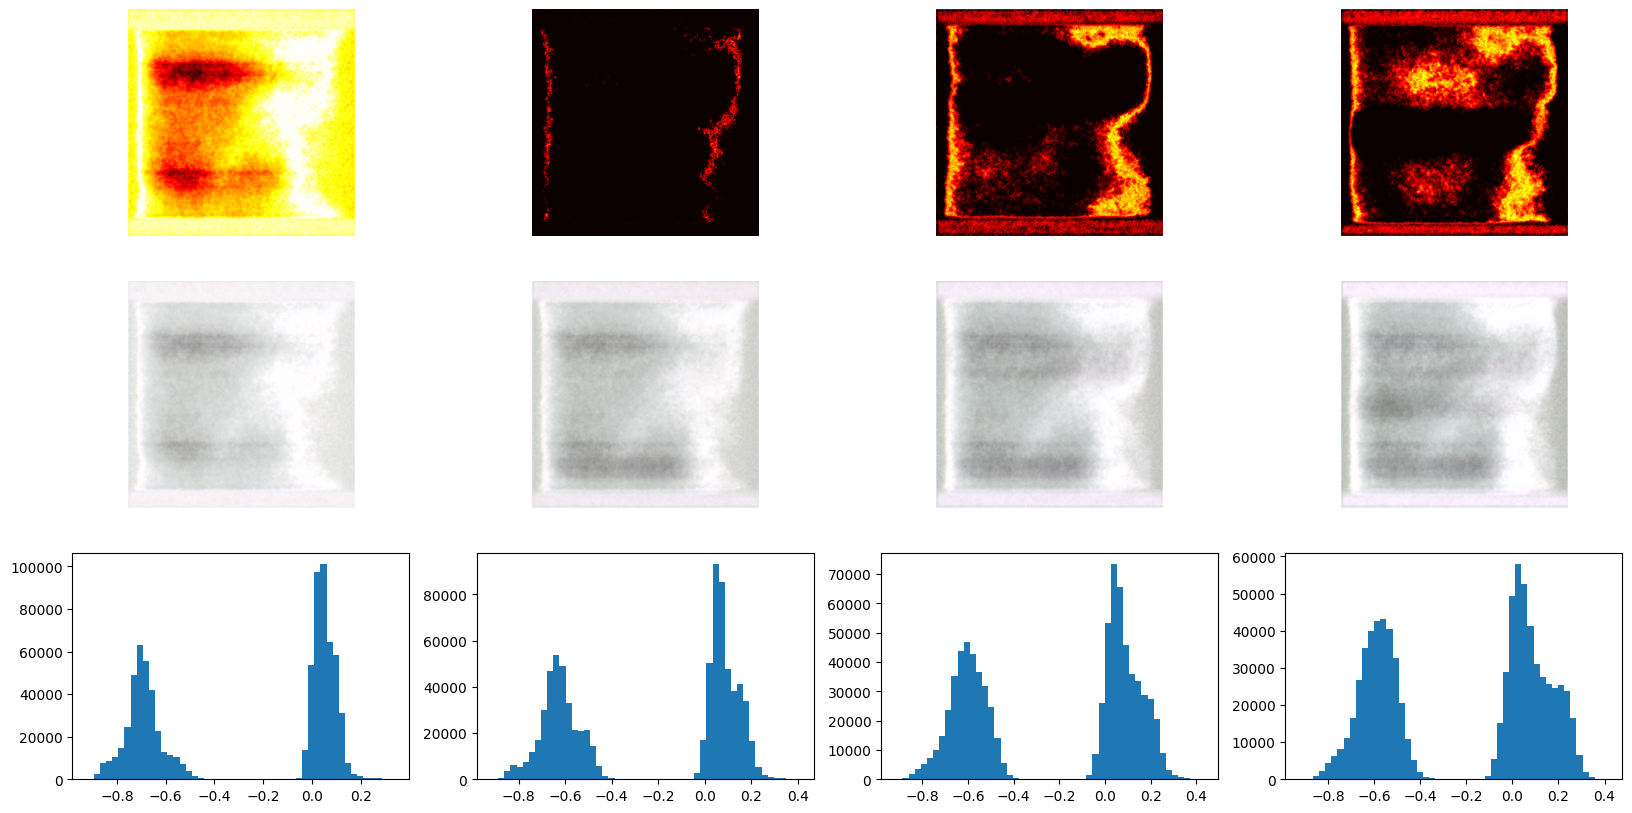

Iteration 400: 0.17337 (reconstruction_loss: 0.17320, aux_loss: 0.00000, p_loss: 0.00000, kld_koss: 0.00017, bce_loss: 0.00000), (lr: 0.0002572125)


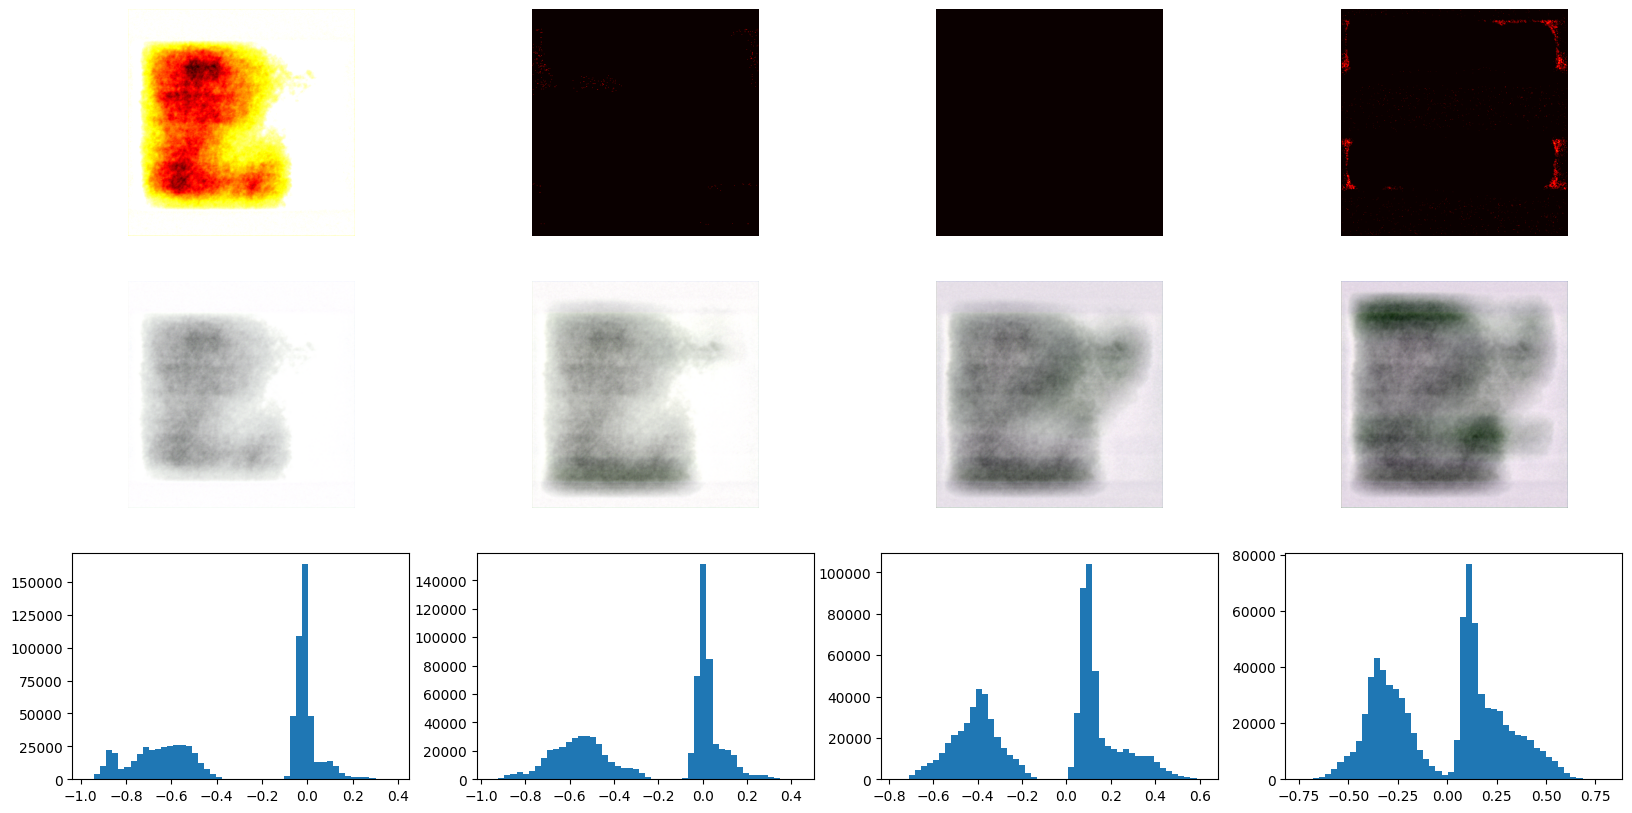

In [ ]:
training_loop(batch, iters=1001, print_every_n=100, lr_update=200)